In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import random
random.seed(12)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from tqdm import tqdm

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import cv2

import math

from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [5]:
class FERDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, dff, transforms):
        'Initialization'
        self.transforms = transforms
        self.dff= pd.read_csv(dff) if type(dff) is str else dff
        
        self.dff['pixels'] = [[int(y) for y in x.split()] for x in self.dff['pixels']]

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.dff)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        #ID = self.list_IDs[index]

        # Load data and get label
        X = self.dff.iloc[index]['pixels']
#         X = X.split()
        X = np.array(X, dtype=np.uint8)
        X = X.reshape(48,48)
        
        y = torch.from_numpy(np.array(self.dff.iloc[index]['emotion'])).long()

        if self.transforms:
            X = self.transforms(X)

#             X = torch.cat((X,X,X),0)

        return X, y

In [4]:
from PIL import Image
class FERDataset(Dataset):
    def __init__(self,csv_file,img_dir,datatype,transform):
        '''
        Pytorch Dataset class
        params:-
                 csv_file : the path of the csv file    (train, validation, test)
                 img_dir  : the directory of the images (train, validation, test)
                 datatype : string for searching along the image_dir (train, val, test)
                 transform: pytorch transformation over the data
        return :-
                 image, labels
        '''
        self.csv_file = pd.read_csv(csv_file)
        self.lables = self.csv_file['emotion']
        self.img_dir = img_dir
        self.transform = transform
        self.datatype = datatype

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = Image.open(self.img_dir+self.datatype+str(idx)+'.jpg')
        lables = np.array(self.lables[idx])
        lables = torch.from_numpy(lables).long()

        if self.transform :
            img = self.transform(img)
        return img,lables

In [15]:
batch_size= 128

df = pd.read_csv('fer2013/fer2013.csv')

df_train = df[df['Usage'] == 'Training']
df_val = df[df['Usage'] == 'PublicTest']
df_test = df[df['Usage'] == 'PrivateTest']


test_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

train_dataset = FERDataset(df_train, test_transforms)
validation_dataset = FERDataset(df_val, test_transforms)
test_set = FERDataset(df_test, test_transforms)


train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, shuffle=True,
                                             num_workers=8)
val_loader = torch.utils.data.DataLoader(validation_dataset,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set,
                                             batch_size=batch_size, shuffle=False,
                                             num_workers=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Deep-emotion model

In [16]:
class Deep_Emotion(nn.Module):
    def __init__(self):
        '''
        Deep_Emotion class contains the network architecture.
        '''
        super(Deep_Emotion,self).__init__()
        self.conv1 = nn.Conv2d(1,10,3)
        self.conv2 = nn.Conv2d(10,10,3)
        self.pool2 = nn.MaxPool2d(2,2)

        self.conv3 = nn.Conv2d(10,10,3)
        self.conv4 = nn.Conv2d(10,10,3)
        self.pool4 = nn.MaxPool2d(2,2)

        self.norm = nn.BatchNorm2d(10)

        self.fc1 = nn.Linear(810,50)
        self.fc2 = nn.Linear(50,7)

        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        self.fc_loc = nn.Sequential(
            nn.Linear(640, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 640)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size(), align_corners=True)
        x = F.grid_sample(x, grid, align_corners=True)
        return x

    def forward(self,input):
        out = self.stn(input)

        out = F.relu(self.conv1(out))
        out = self.conv2(out)
        out = F.relu(self.pool2(out))

        out = F.relu(self.conv3(out))
        out = self.norm(self.conv4(out))
        out = F.relu(self.pool4(out))

        out = F.dropout(out)
        out = out.view(-1, 810)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)

        return out

In [17]:
device = torch.device('cuda')
net = Deep_Emotion().to(device)

best_acc = 0.0
hist = []

epochs=100

criterion = nn.CrossEntropyLoss()

learning_rate = 0.005
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=learning_rate, weight_decay=1e-4, nesterov=True)
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.75, patience=5, verbose=True)


In [18]:
def Train(epochs,train_loader,val_loader,criterion,optmizer,device):
    '''
    Training Loop
    '''
    print("===================================Start Training===================================")
    for e in range(epochs):
        train_loss = 0
        validation_loss = 0
        train_correct = 0
        val_correct = 0
        # Train the model  #
        net.train()
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device)
            optmizer.zero_grad()
            outputs = net(data)
            loss = criterion(outputs,labels)
            loss.backward()
            optmizer.step()
            train_loss += loss.item()
            _, preds = torch.max(outputs,1)
            train_correct += torch.sum(preds == labels.data)

        #validate the model#
        net.eval()
        for data,labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            val_outputs = net(data)
            val_loss = criterion(val_outputs, labels)
            validation_loss += val_loss.item()
            _, val_preds = torch.max(val_outputs,1)
            val_correct += torch.sum(val_preds == labels.data)

        train_loss = train_loss/len(train_dataset)
        train_acc = train_correct.double() / len(train_dataset)
        validation_loss =  validation_loss / len(validation_dataset)
        val_acc = val_correct.double() / len(validation_dataset)
        print('Epoch: {} \tTraining Loss: {:.8f} \tValidation Loss {:.8f} \tTraining Acuuarcy {:.3f}% \tValidation Acuuarcy {:.3f}%'
                                                           .format(e+1, train_loss,validation_loss,train_acc * 100, val_acc*100))

#     torch.save(net.state_dict(),'deep_emotion-{}-{}-{}.pt'.format(epochs,batchsize,lr))
    print("===================================Training Finished===================================")

In [19]:
Train(epochs,train_loader,val_loader,criterion,optimizer,device)

===================================Start Training===================================
Epoch: 1 	Training Loss: 0.01572445 	Validation Loss 0.01620923 	Training Acuuarcy 13.999% 	Validation Acuuarcy 14.405%
Epoch: 2 	Training Loss: 0.01571130 	Validation Loss 0.01625473 	Training Acuuarcy 14.083% 	Validation Acuuarcy 13.904%
Epoch: 3 	Training Loss: 0.01571757 	Validation Loss 0.01623749 	Training Acuuarcy 14.264% 	Validation Acuuarcy 13.876%
Epoch: 4 	Training Loss: 0.01572135 	Validation Loss 0.01623888 	Training Acuuarcy 14.142% 	Validation Acuuarcy 13.876%
Epoch: 5 	Training Loss: 0.01571171 	Validation Loss 0.01620427 	Training Acuuarcy 14.351% 	Validation Acuuarcy 14.461%
Epoch: 6 	Training Loss: 0.01571037 	Validation Loss 0.01616150 	Training Acuuarcy 14.058% 	Validation Acuuarcy 13.959%
Epoch: 7 	Training Loss: 0.01571810 	Validation Loss 0.01628585 	Training Acuuarcy 14.180% 	Validation Acuuarcy 13.876%
Epoch: 8 	Training Loss: 0.01570586 	Validation Loss 0.01627155 	Training A

KeyboardInterrupt: 

In [26]:
model_path = 'vanilla_deepemotion_model.pt'

for epoch in range(epochs):  # loop over the dataset multiple times

    print('Epoch: ', epoch + 1)
    running_loss = 0.0
    running_acc = 0.0
    processed = 0.0

    # TRAIN
    model.train()
    pbar = tqdm(train_loader, position=0)
    for i, data in enumerate(pbar):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()
        loss.backward()
        
        optimizer.step()

        # print statistics
        running_loss += (loss.item() * inputs.size(0))
        running_acc += acc.item()
        processed += len(inputs)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={i} Accuracy={acc.item() / inputs.size(0)}')

    print('- Avg.loss: %.3f | Avg.acc: %.3f' % (running_loss / len(train_loader.dataset), running_acc / len(train_loader.dataset)))
    avgloss = running_loss / len(train_loader.dataset)
    avgacc = running_acc / len(train_loader.dataset)

    # EVALUATE
    model.eval()
    running_valloss = 0.0
    running_valacc = 0.0
    for i,data in enumerate(val_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        
        loss = criterion(outputs, labels)
        acc = (torch.argmax(outputs, dim=1) == labels).float().sum()

        running_valloss += (loss.item() * inputs.size(0))
        running_valacc += acc.item()

    print('- Avg. val_loss: %.3f | Avg. val_acc: %.3f' % (running_valloss / len(val_loader.dataset), running_valacc / len(val_loader.dataset)))

    avgvalloss = running_valloss / len(val_loader.dataset)
    avgvalacc = running_valacc / len(val_loader.dataset)
    
#     scheduler.step(avgvalacc)

    hist.append([avgloss, avgvalloss, avgacc, avgvalacc])
    
    if best_acc < avgvalacc:
        best_acc = avgvalacc
        torch.save(model, model_path)
        print('* Update optimal model')

print('Finished Training')

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch:  1


Loss=1.5641014575958252 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:04<00:00, 47.77it/s]

- Avg.loss: 1.699 | Avg.acc: 0.318



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.582 | Avg. val_acc: 0.383
* Update optimal model
Epoch:  2


Loss=1.3205668926239014 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.47it/s]

- Avg.loss: 1.554 | Avg.acc: 0.393



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.561 | Avg. val_acc: 0.385
* Update optimal model
Epoch:  3


Loss=1.6437495946884155 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.75it/s]

- Avg.loss: 1.495 | Avg.acc: 0.420



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.498 | Avg. val_acc: 0.427
* Update optimal model
Epoch:  4


Loss=1.3447831869125366 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.56it/s]

- Avg.loss: 1.456 | Avg.acc: 0.434



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.761 | Avg. val_acc: 0.311
Epoch:  5


Loss=1.557634711265564 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.64it/s]

- Avg.loss: 1.427 | Avg.acc: 0.450



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.403 | Avg. val_acc: 0.467
* Update optimal model
Epoch:  6


Loss=1.3418102264404297 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 47.70it/s]

- Avg.loss: 1.408 | Avg.acc: 0.456



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.413 | Avg. val_acc: 0.447
Epoch:  7


Loss=1.2859292030334473 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.75it/s]


- Avg.loss: 1.393 | Avg.acc: 0.463


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.407 | Avg. val_acc: 0.456
Epoch:  8


Loss=1.5454273223876953 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.19it/s]

- Avg.loss: 1.377 | Avg.acc: 0.471



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.402 | Avg. val_acc: 0.468
* Update optimal model
Epoch:  9


Loss=1.5432504415512085 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:04<00:00, 47.55it/s]

- Avg.loss: 1.368 | Avg.acc: 0.478



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.401 | Avg. val_acc: 0.463
Epoch:  10


Loss=1.2157808542251587 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 46.58it/s]

- Avg.loss: 1.366 | Avg.acc: 0.478



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.393 | Avg. val_acc: 0.480
* Update optimal model
Epoch:  11


Loss=1.2134863138198853 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.68it/s]

- Avg.loss: 1.355 | Avg.acc: 0.481



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.405 | Avg. val_acc: 0.459
Epoch:  12


Loss=1.2692607641220093 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 48.79it/s]

- Avg.loss: 1.356 | Avg.acc: 0.478



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.381 | Avg. val_acc: 0.474
Epoch:  13


Loss=1.3533273935317993 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.75it/s]

- Avg.loss: 1.351 | Avg.acc: 0.482



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.382 | Avg. val_acc: 0.468
Epoch:  14


Loss=1.4765052795410156 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 46.31it/s]

- Avg.loss: 1.350 | Avg.acc: 0.485



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.390 | Avg. val_acc: 0.473
Epoch:  15


Loss=1.3068249225616455 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.76it/s]

- Avg.loss: 1.342 | Avg.acc: 0.486



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.386 | Avg. val_acc: 0.472
Epoch:  16


Loss=1.2199149131774902 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 48.18it/s]

- Avg.loss: 1.341 | Avg.acc: 0.485



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.354 | Avg. val_acc: 0.481
* Update optimal model
Epoch:  17


Loss=1.3705754280090332 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.70it/s]

- Avg.loss: 1.329 | Avg.acc: 0.491



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.374 | Avg. val_acc: 0.486
* Update optimal model
Epoch:  18


Loss=1.1472011804580688 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.69it/s]


- Avg.loss: 1.332 | Avg.acc: 0.488


  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.366 | Avg. val_acc: 0.468
Epoch:  19


Loss=1.333820104598999 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.18it/s]

- Avg.loss: 1.327 | Avg.acc: 0.493



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.365 | Avg. val_acc: 0.481
Epoch:  20


Loss=1.1657071113586426 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.57it/s]

- Avg.loss: 1.319 | Avg.acc: 0.496



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.366 | Avg. val_acc: 0.488
* Update optimal model
Epoch:  21


Loss=1.4073070287704468 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 48.54it/s]

- Avg.loss: 1.324 | Avg.acc: 0.495



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.421 | Avg. val_acc: 0.457
Epoch:  22


Loss=1.2912184000015259 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 48.29it/s]

- Avg.loss: 1.309 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.390 | Avg. val_acc: 0.473
Epoch:  23


Loss=0.9850225448608398 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:04<00:00, 48.04it/s]

- Avg.loss: 1.313 | Avg.acc: 0.498



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.396 | Avg. val_acc: 0.464
Epoch:  24


Loss=1.2796504497528076 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.68it/s]

- Avg.loss: 1.306 | Avg.acc: 0.497



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.346 | Avg. val_acc: 0.484
Epoch:  25


Loss=1.0563865900039673 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 46.89it/s]

- Avg.loss: 1.301 | Avg.acc: 0.501



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.488
Epoch:  26


Loss=1.285032868385315 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 47.32it/s]

- Avg.loss: 1.299 | Avg.acc: 0.500



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.356 | Avg. val_acc: 0.486
Epoch:  27


Loss=1.3314464092254639 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.57it/s]

- Avg.loss: 1.292 | Avg.acc: 0.506



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.372 | Avg. val_acc: 0.480
Epoch:  28


Loss=1.5071847438812256 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.67it/s]

- Avg.loss: 1.297 | Avg.acc: 0.506



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.356 | Avg. val_acc: 0.492
* Update optimal model
Epoch:  29


Loss=1.5195562839508057 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.66it/s]

- Avg.loss: 1.291 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.496
* Update optimal model
Epoch:  30


Loss=1.1515567302703857 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:04<00:00, 46.79it/s]

- Avg.loss: 1.289 | Avg.acc: 0.507



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.344 | Avg. val_acc: 0.490
Epoch:  31


Loss=1.1489932537078857 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 47.48it/s]

- Avg.loss: 1.273 | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.353 | Avg. val_acc: 0.480
Epoch:  32


Loss=1.1084487438201904 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:04<00:00, 47.43it/s]

- Avg.loss: 1.276 | Avg.acc: 0.511



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.348 | Avg. val_acc: 0.490
Epoch:  33


Loss=1.4707200527191162 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.65it/s]

- Avg.loss: 1.275 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.336 | Avg. val_acc: 0.480
Epoch:  34


Loss=1.4399915933609009 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.79it/s]

- Avg.loss: 1.276 | Avg.acc: 0.512



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.366 | Avg. val_acc: 0.484
Epoch:  35


Loss=1.4059741497039795 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.73it/s]

- Avg.loss: 1.280 | Avg.acc: 0.513



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.333 | Avg. val_acc: 0.505
* Update optimal model
Epoch:  36


Loss=1.2174800634384155 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.18it/s]

- Avg.loss: 1.277 | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.331 | Avg. val_acc: 0.497
Epoch:  37


Loss=1.202404260635376 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 48.15it/s]

- Avg.loss: 1.272 | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.344 | Avg. val_acc: 0.484
Epoch:  38


Loss=1.2570079565048218 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.29it/s]

- Avg.loss: 1.269 | Avg.acc: 0.516



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.340 | Avg. val_acc: 0.487
Epoch:  39


Loss=1.4374568462371826 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.56it/s]

- Avg.loss: 1.265 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.314 | Avg. val_acc: 0.504
Epoch:  40


Loss=1.3270411491394043 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.11it/s]

- Avg.loss: 1.263 | Avg.acc: 0.519



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.322 | Avg. val_acc: 0.495
Epoch:  41


Loss=1.08220636844635 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:04<00:00, 46.30it/s]

- Avg.loss: 1.262 | Avg.acc: 0.521



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.338 | Avg. val_acc: 0.502
Epoch:  42


Loss=1.2973558902740479 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 48.07it/s]

- Avg.loss: 1.258 | Avg.acc: 0.517



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.486
Epoch:  43


Loss=1.4054187536239624 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 47.88it/s]

- Avg.loss: 1.270 | Avg.acc: 0.515



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.341 | Avg. val_acc: 0.490
Epoch:  44


Loss=1.5362961292266846 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 48.28it/s]

- Avg.loss: 1.258 | Avg.acc: 0.521



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.319 | Avg. val_acc: 0.503
Epoch:  45


Loss=1.2161693572998047 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 46.72it/s]

- Avg.loss: 1.264 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.316 | Avg. val_acc: 0.501
Epoch:  46


Loss=1.2428696155548096 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 48.30it/s]

- Avg.loss: 1.260 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.354 | Avg. val_acc: 0.490
Epoch:  47


Loss=1.2952946424484253 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 46.52it/s]

- Avg.loss: 1.262 | Avg.acc: 0.521



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.330 | Avg. val_acc: 0.500
Epoch:  48


Loss=1.7290376424789429 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:04<00:00, 47.87it/s]

- Avg.loss: 1.257 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.339 | Avg. val_acc: 0.498
Epoch:  49


Loss=1.5048284530639648 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.26it/s]

- Avg.loss: 1.259 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.321 | Avg. val_acc: 0.502
Epoch:  50


Loss=0.9669336676597595 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:04<00:00, 48.42it/s]

- Avg.loss: 1.251 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.343 | Avg. val_acc: 0.481
Epoch:  51


Loss=1.3449681997299194 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:04<00:00, 47.85it/s]

- Avg.loss: 1.251 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.347 | Avg. val_acc: 0.483
Epoch:  52


Loss=1.3799227476119995 Batch_id=224 Accuracy=0.40540540540540543: 100%|██████████| 225/225 [00:04<00:00, 47.64it/s]

- Avg.loss: 1.258 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.325 | Avg. val_acc: 0.499
Epoch:  53


Loss=0.9553684592247009 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 47.02it/s]

- Avg.loss: 1.249 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.338 | Avg. val_acc: 0.494
Epoch:  54


Loss=1.5496547222137451 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:04<00:00, 47.76it/s]

- Avg.loss: 1.255 | Avg.acc: 0.522



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.320 | Avg. val_acc: 0.505
Epoch:  55


Loss=1.1928455829620361 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 46.64it/s]

- Avg.loss: 1.252 | Avg.acc: 0.525



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.297 | Avg. val_acc: 0.512
* Update optimal model
Epoch:  56


Loss=1.3342993259429932 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.03it/s]

- Avg.loss: 1.246 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.326 | Avg. val_acc: 0.495
Epoch:  57


Loss=1.1076022386550903 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 48.12it/s]

- Avg.loss: 1.251 | Avg.acc: 0.523



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.504
Epoch:  58


Loss=1.1612870693206787 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.41it/s]

- Avg.loss: 1.248 | Avg.acc: 0.520



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.314 | Avg. val_acc: 0.497
Epoch:  59


Loss=1.1221685409545898 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 47.39it/s]

- Avg.loss: 1.260 | Avg.acc: 0.518



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.304 | Avg. val_acc: 0.514
* Update optimal model
Epoch:  60


Loss=1.1496386528015137 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:04<00:00, 47.28it/s]

- Avg.loss: 1.238 | Avg.acc: 0.529



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.349 | Avg. val_acc: 0.485
Epoch:  61


Loss=1.4044647216796875 Batch_id=224 Accuracy=0.43243243243243246: 100%|██████████| 225/225 [00:04<00:00, 47.32it/s]

- Avg.loss: 1.244 | Avg.acc: 0.526



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.305 | Avg. val_acc: 0.504
Epoch:  62


Loss=1.5142543315887451 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 48.16it/s]

- Avg.loss: 1.233 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.317 | Avg. val_acc: 0.498
Epoch:  63


Loss=1.2525560855865479 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 48.05it/s]

- Avg.loss: 1.243 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.308 | Avg. val_acc: 0.503
Epoch:  64


Loss=1.6213549375534058 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:04<00:00, 48.10it/s]

- Avg.loss: 1.233 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.328 | Avg. val_acc: 0.493
Epoch:  65


Loss=1.2827484607696533 Batch_id=224 Accuracy=0.5945945945945946: 100%|██████████| 225/225 [00:04<00:00, 47.34it/s]

- Avg.loss: 1.232 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.301 | Avg. val_acc: 0.509
Epoch:  66


Loss=1.3333920240402222 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:04<00:00, 47.84it/s]

- Avg.loss: 1.231 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.302 | Avg. val_acc: 0.506
Epoch:  67


Loss=1.3284122943878174 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.58it/s]

- Avg.loss: 1.234 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.335 | Avg. val_acc: 0.488
Epoch:  68


Loss=1.2049885988235474 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:05<00:00, 38.78it/s]

- Avg.loss: 1.232 | Avg.acc: 0.533



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.329 | Avg. val_acc: 0.499
Epoch:  69


Loss=1.3099651336669922 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:05<00:00, 38.39it/s]

- Avg.loss: 1.235 | Avg.acc: 0.530



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.311 | Avg. val_acc: 0.493
Epoch:  70


Loss=1.6080844402313232 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:06<00:00, 32.92it/s]

- Avg.loss: 1.226 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.299 | Avg. val_acc: 0.511
Epoch:  71


Loss=1.361729621887207 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:06<00:00, 36.57it/s]

- Avg.loss: 1.225 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.309 | Avg. val_acc: 0.500
Epoch:  72


Loss=1.1049660444259644 Batch_id=224 Accuracy=0.6216216216216216: 100%|██████████| 225/225 [00:07<00:00, 30.93it/s]

- Avg.loss: 1.225 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.334 | Avg. val_acc: 0.498
Epoch:  73


Loss=1.0524437427520752 Batch_id=224 Accuracy=0.6486486486486487: 100%|██████████| 225/225 [00:04<00:00, 46.62it/s]

- Avg.loss: 1.231 | Avg.acc: 0.531



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.295 | Avg. val_acc: 0.508
Epoch:  74


Loss=1.1745096445083618 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.68it/s]

- Avg.loss: 1.224 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.333 | Avg. val_acc: 0.495
Epoch:  75


Loss=1.093298077583313 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 46.60it/s]

- Avg.loss: 1.234 | Avg.acc: 0.528



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.308 | Avg. val_acc: 0.501
Epoch:  76


Loss=1.253873348236084 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.70it/s]

- Avg.loss: 1.219 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.303 | Avg. val_acc: 0.502
Epoch:  77


Loss=1.0460971593856812 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 46.92it/s]

- Avg.loss: 1.218 | Avg.acc: 0.537



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.295 | Avg. val_acc: 0.510
Epoch:  78


Loss=1.2837656736373901 Batch_id=224 Accuracy=0.4864864864864865: 100%|██████████| 225/225 [00:04<00:00, 47.76it/s]

- Avg.loss: 1.223 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.324 | Avg. val_acc: 0.497
Epoch:  79


Loss=1.4161211252212524 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 46.50it/s]

- Avg.loss: 1.219 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.352 | Avg. val_acc: 0.493
Epoch:  80


Loss=1.5938036441802979 Batch_id=224 Accuracy=0.32432432432432434: 100%|██████████| 225/225 [00:04<00:00, 47.19it/s]

- Avg.loss: 1.210 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.319 | Avg. val_acc: 0.502
Epoch:  81


Loss=1.35369074344635 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 46.94it/s]

- Avg.loss: 1.222 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.313 | Avg. val_acc: 0.510
Epoch:  82


Loss=1.1796875 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.13it/s]

- Avg.loss: 1.222 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.295 | Avg. val_acc: 0.511
Epoch:  83


Loss=1.2190948724746704 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.39it/s]

- Avg.loss: 1.218 | Avg.acc: 0.532



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.308 | Avg. val_acc: 0.506
Epoch:  84


Loss=1.1257295608520508 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.42it/s]

- Avg.loss: 1.207 | Avg.acc: 0.541



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.274 | Avg. val_acc: 0.520
* Update optimal model
Epoch:  85


Loss=0.9974730014801025 Batch_id=224 Accuracy=0.7027027027027027: 100%|██████████| 225/225 [00:04<00:00, 47.83it/s]

- Avg.loss: 1.218 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.297 | Avg. val_acc: 0.515
Epoch:  86


Loss=1.143131136894226 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 46.70it/s]

- Avg.loss: 1.217 | Avg.acc: 0.534



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.293 | Avg. val_acc: 0.507
Epoch:  87


Loss=1.1719942092895508 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 46.32it/s]

- Avg.loss: 1.210 | Avg.acc: 0.539



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.308 | Avg. val_acc: 0.508
Epoch:  88


Loss=1.1630758047103882 Batch_id=224 Accuracy=0.5405405405405406: 100%|██████████| 225/225 [00:04<00:00, 47.76it/s]

- Avg.loss: 1.210 | Avg.acc: 0.536



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.294 | Avg. val_acc: 0.506
Epoch:  89


Loss=1.1783281564712524 Batch_id=224 Accuracy=0.5675675675675675: 100%|██████████| 225/225 [00:04<00:00, 47.66it/s]

- Avg.loss: 1.206 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.353 | Avg. val_acc: 0.487
Epoch:  90


Loss=1.1180050373077393 Batch_id=224 Accuracy=0.5135135135135135: 100%|██████████| 225/225 [00:04<00:00, 47.12it/s]

- Avg.loss: 1.212 | Avg.acc: 0.535



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.307 | Avg. val_acc: 0.510
Epoch:  91


Loss=0.9508988857269287 Batch_id=224 Accuracy=0.6756756756756757: 100%|██████████| 225/225 [00:04<00:00, 48.21it/s]

- Avg.loss: 1.208 | Avg.acc: 0.542



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.284 | Avg. val_acc: 0.507
Epoch:  92


Loss=1.3497393131256104 Batch_id=224 Accuracy=0.4594594594594595: 100%|██████████| 225/225 [00:04<00:00, 47.02it/s]

- Avg.loss: 1.207 | Avg.acc: 0.540



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.307 | Avg. val_acc: 0.512
Epoch:  93


Loss=1.7637368440628052 Batch_id=224 Accuracy=0.24324324324324326: 100%|██████████| 225/225 [00:04<00:00, 46.30it/s]

- Avg.loss: 1.586 | Avg.acc: 0.365



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.811 | Avg. val_acc: 0.249
Epoch:  94


Loss=1.8136786222457886 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:04<00:00, 47.05it/s]

- Avg.loss: 1.818 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 7.860 | Avg. val_acc: 0.239
Epoch:  95


Loss=1.7963587045669556 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:04<00:00, 46.86it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.814 | Avg. val_acc: 0.249
Epoch:  96


Loss=1.863255262374878 Batch_id=224 Accuracy=0.1891891891891892: 100%|██████████| 225/225 [00:04<00:00, 47.53it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.961 | Avg. val_acc: 0.249
Epoch:  97


Loss=1.7483161687850952 Batch_id=224 Accuracy=0.35135135135135137: 100%|██████████| 225/225 [00:04<00:00, 47.67it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.980 | Avg. val_acc: 0.249
Epoch:  98


Loss=1.810402274131775 Batch_id=224 Accuracy=0.2972972972972973: 100%|██████████| 225/225 [00:04<00:00, 46.64it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 1.990 | Avg. val_acc: 0.250
Epoch:  99


Loss=1.6740468740463257 Batch_id=224 Accuracy=0.3783783783783784: 100%|██████████| 225/225 [00:04<00:00, 48.09it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251



  0%|          | 0/225 [00:00<?, ?it/s]

- Avg. val_loss: 2.014 | Avg. val_acc: 0.249
Epoch:  100


Loss=1.804056167602539 Batch_id=224 Accuracy=0.2702702702702703: 100%|██████████| 225/225 [00:04<00:00, 46.98it/s]

- Avg.loss: 1.812 | Avg.acc: 0.251


- Avg. val_loss: 1.968 | Avg. val_acc: 0.250
Finished Training


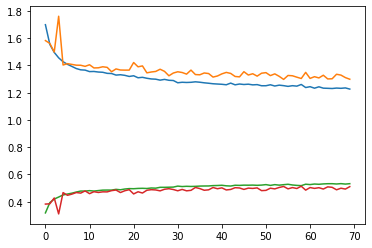

In [27]:
plt.plot(np.array(hist)[:70])